In [1]:
# Remember you need to use SWAN with NXCALS support.dgamba...
import datetime
import pytimber
ldb = pytimber.LoggingDB(source="nxcals")

kinit: type the password for `dgamba`:········


In [2]:
# Just some simple imports
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['lines.linewidth'] = 2


### Looking at some SEM data

In [7]:
# One night data where SEM in Injection line were in:
t1 = '2021-09-27 20:00:00.000'
t2 = '2021-09-28 08:00:00.000'

# List of SEM signals
SEMList_intensity = ['LNI.BSGW.0030:FitAcq:gaussAmplitude','LNI.BSGW.0060:FitAcq:gaussAmplitude']
SEMList_position = ['LNI.BSGW.0030:FitAcq:gaussMean','LNI.BSGW.0060:FitAcq:gaussMean']
SEMList_sigmas = ['LNI.BSGW.0030:FitAcq:gaussSigma','LNI.BSGW.0060:FitAcq:gaussSigma']

# GET the data from NXCALS via PyTimber
# ****** [SLOW part of the code!] ********
SEM_intensity = ldb.get(SEMList_intensity, t1, t2)
SEM_position  = ldb.get(SEMList_position, t1, t2)
SEM_sigmas    = ldb.get(SEMList_sigmas, t1, t2)

In [11]:
# Print keys in side a dictionary
SEM_intensity.keys()

dict_keys(['LNI.BSGW.0030:FitAcq:gaussAmplitude', 'LNI.BSGW.0060:FitAcq:gaussAmplitude'])

In [17]:
# Print first 3 ([0:3]) timestamps ([0])
SEM_intensity['LNI.BSGW.0030:FitAcq:gaussAmplitude'][0][0:3]

array([1.63276574e+09, 1.63276588e+09, 1.63276603e+09])

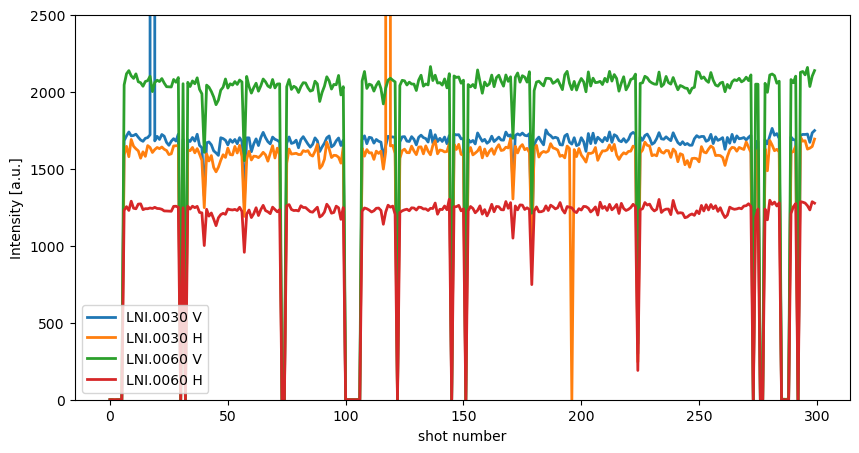

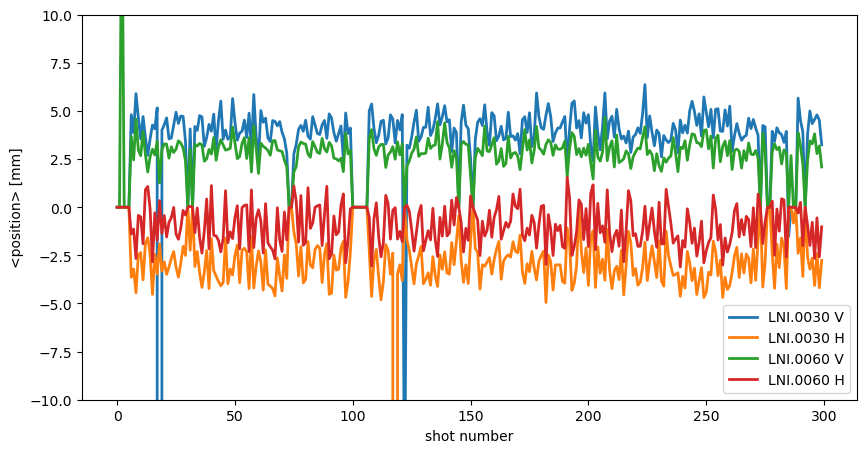

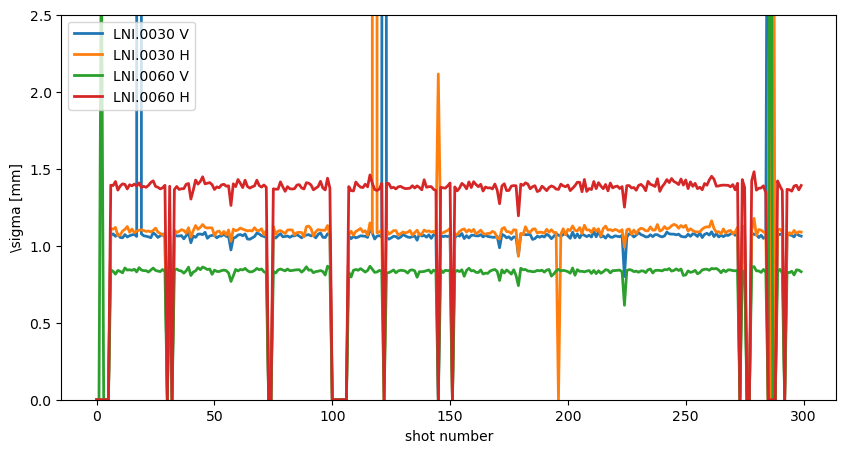

In [18]:
# Intensity
plt.figure()
plt.plot(SEM_intensity['LNI.BSGW.0030:FitAcq:gaussAmplitude'][1][:,0], label='LNI.0030 V')
plt.plot(SEM_intensity['LNI.BSGW.0030:FitAcq:gaussAmplitude'][1][:,1], label='LNI.0030 H')
plt.plot(SEM_intensity['LNI.BSGW.0060:FitAcq:gaussAmplitude'][1][:,0], label='LNI.0060 V')
plt.plot(SEM_intensity['LNI.BSGW.0060:FitAcq:gaussAmplitude'][1][:,1], label='LNI.0060 H')
plt.xlabel("shot number")
plt.ylabel("Intensity [a.u.]")
plt.ylim([0, 2.5e3])
plt.legend()

# Position
plt.figure()
plt.plot(SEM_position['LNI.BSGW.0030:FitAcq:gaussMean'][1][:,0], label='LNI.0030 V')
plt.plot(SEM_position['LNI.BSGW.0030:FitAcq:gaussMean'][1][:,1], label='LNI.0030 H')
plt.plot(SEM_position['LNI.BSGW.0060:FitAcq:gaussMean'][1][:,0], label='LNI.0060 V')
plt.plot(SEM_position['LNI.BSGW.0060:FitAcq:gaussMean'][1][:,1], label='LNI.0060 H')
plt.xlabel("shot number")
plt.ylabel("<position> [mm]")
plt.ylim([-10, 10])
plt.legend()

# Sigma
plt.figure()
plt.plot(SEM_sigmas['LNI.BSGW.0030:FitAcq:gaussSigma'][1][:,0], label='LNI.0030 V')
plt.plot(SEM_sigmas['LNI.BSGW.0030:FitAcq:gaussSigma'][1][:,1], label='LNI.0030 H')
plt.plot(SEM_sigmas['LNI.BSGW.0060:FitAcq:gaussSigma'][1][:,0], label='LNI.0060 V')
plt.plot(SEM_sigmas['LNI.BSGW.0060:FitAcq:gaussSigma'][1][:,1], label='LNI.0060 H')
plt.xlabel("shot number")
plt.ylabel("\sigma [mm]")
plt.ylim([0, 2.5])
plt.legend()


# Effect of AeGIS magnet on orbit in LNE00++

We are interested in looking at "mean" position as a function of time for a few monitors.
- We will ~automatically generate a list of good monitors (e.g. the ones from ELENA to a given Experiment)
- We will try to plot only "good data", thanks to the features provided by the SEM FESA class (assuming it does what one expects...)

In [19]:
ldb.search('LNE00%FitAcq:gaussMean')

['LNE00.BSGW.0008:FitAcq:gaussMean',
 'LNE00.BSGW.0015:FitAcq:gaussMean',
 'LNE00.BSGW.0025:FitAcq:gaussMean',
 'LNE00.BSGW.0038:FitAcq:gaussMean',
 'LNE00.BSGW.0045:FitAcq:gaussMean']

In [20]:
# One night data where SEM in Injection line were in:
t1 = '2021-11-03 10:00:00.000'
t2 = '2021-11-03 24:00:00.000'

# Get a list of monitors following some "rule", e.g. concatenating different pieces of LNEXX lines
ALL_MONITORS = (ldb.search('LNE00%FitAcq:gaussMean')+
    ldb.search('LNE01%FitAcq:gaussMean')+
    ldb.search('LNE03%FitAcq:gaussMean')+
    ldb.search('LNE04%FitAcq:gaussMean'))

# We will also need to know if the profiles are good, so we need some other field
# Here we use several "tricks" typical of python
# 1. inline creation of a list of elements (in our case will be strings)
#    [ element1, element2, ... ]
# 2. inline *for loop* to make the list of elements
#    [ _do_something_with_element_  for _element_ in _list_of_elements_]
# 3. profit of standard operation on strings, e.g. "split"
#    _my_string_.split(separator_characther, number_of_splits)
# 4. immediatelly take the first element of the list generated by "split" function
#    _my_function_that_returns_a_list()[0] -> returns the first element of the list
# 5. string concatenation
#    "_first_string_" + "_second_string_" = "_first_string__second_string_"
_ALL_MONITORS_IN = [ _monitor.split(':',1)[0]+':Acquisition:isMonitorIn' for _monitor in ALL_MONITORS]

# same for intensity/Amplitude
_ALL_MONITORS_AMPLI = [ _monitor.split(':',1)[0]+':FitAcq:gaussAmplitude' for _monitor in ALL_MONITORS]
_ALL_MONITORS_SIGMA = [ _monitor.split(':',1)[0]+':FitAcq:gaussSigma' for _monitor in ALL_MONITORS]

In [21]:
# GET the data from NXCALS via PyTimber 
# ****** [SLOW part of the code!] ********
SEM_position_data  = ldb.get(ALL_MONITORS+_ALL_MONITORS_IN+_ALL_MONITORS_AMPLI+_ALL_MONITORS_SIGMA, t1, t2)

### Now the real data analysis
Plot all data, but first find ways to filter out bad data...

<ipython-input-13-d8cbbd37b225>:51: RuntimeWarning: overflow encountered in multiply
  _good_intensity_v = np.multiply(_amplitude_v, _sigma_v) > intensity_threshold
<ipython-input-13-d8cbbd37b225>:51: RuntimeWarning: overflow encountered in multiply
  _good_intensity_v = np.multiply(_amplitude_v, _sigma_v) > intensity_threshold
<ipython-input-13-d8cbbd37b225>:52: RuntimeWarning: overflow encountered in multiply
  _good_intensity_h = np.multiply(_amplitude_h, _sigma_h) > intensity_threshold


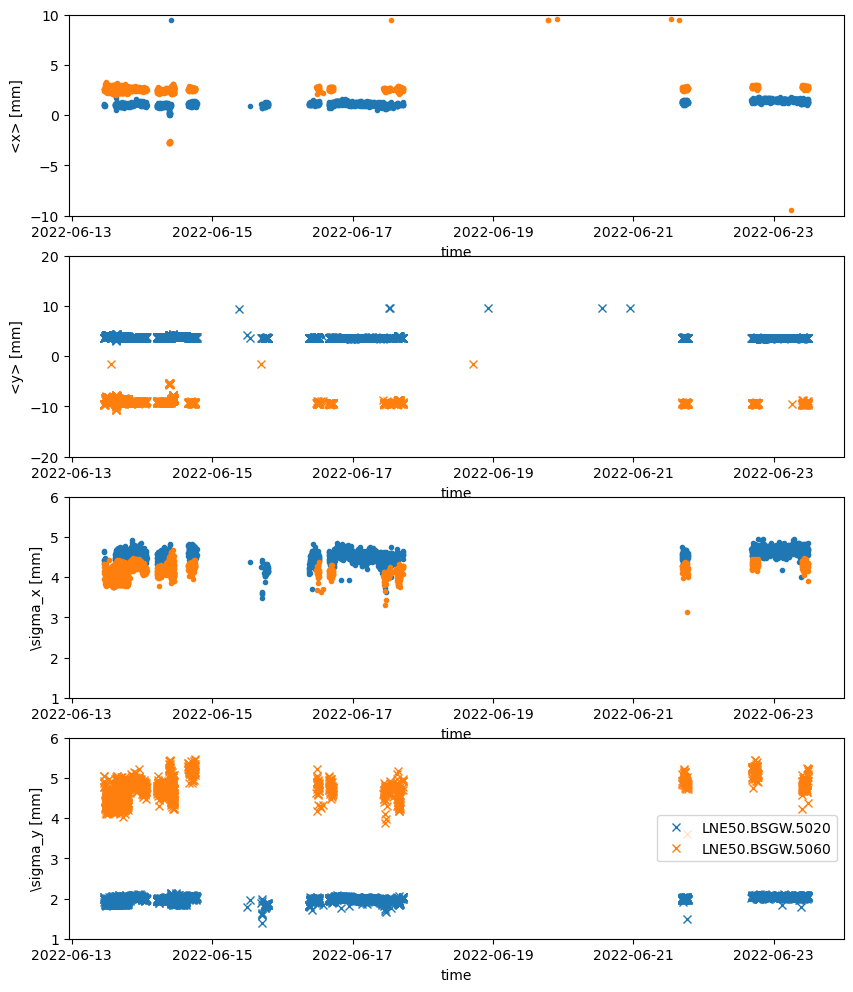

In [13]:
# Let's define an intensity threshold to "clean" up the plot
intensity_threshold = 500

# and eventually the times to zoom in
zoom_start_time = datetime.datetime.strptime('2021-11-03 12:30', '%Y-%m-%d %H:%M')
zoom_end_time   = datetime.datetime.strptime('2021-11-03 15:30', '%Y-%m-%d %H:%M')

########################################
# Start preparing a couple of subplots:
plt.figure(figsize=[10,12])
ax1 = plt.subplot(4,1,1)
ax2 = plt.subplot(4,1,2)
ax3 = plt.subplot(4,1,3)
ax4 = plt.subplot(4,1,4)



########################################
# Plot monitor by monitor...
for _i, _monitor in enumerate(ALL_MONITORS):
    
    # first element (index 0) in the dictionary returned by pytimber is the "acquisition time" from NXCALS of 
    #   the requested data.
    _times_data  = SEM_position_data[_monitor][0]
    # typically we are talking about a timestamp in ns, so better we convert it in "datetime" python objects
    #  and we put it in a "numpy array"
    _times = np.array([datetime.datetime.fromtimestamp(_time) for _time in _times_data])
    
    # second element (index 1) is the actual data
    _values = SEM_position_data[_monitor][1]
    # for SEM, "gaussMean" of a single acquisition is a 2-element array, so in NXCALS data 
    #   is returned as a Nx2 matrix, where "N" are the number of acquisitions in the requested time range
    _values_v = _values[:, 0]
    _values_h = _values[:, 1]
    
    # _ALL_MONITORS_IN is ordered following ALL_MONITORS, so i profit of "enumerate" for loop 
    #   to get the information of the monitor being IN or not
    # I also don't care about the time, assuming that data is synchronised with "gaussMean" variable
    #   so we can immediatelly take element [1], i.e. the value
    # and convert it as boolean (as it should be already... but NXCALS + PyTimber did not understand it...)
    _monitor_in = SEM_position_data[_ALL_MONITORS_IN[_i]][1].astype('bool')
    
    # Same idea for the intensity/sigma values
    #  Extract immediatelly the intensity [1] for both planes [:, (0|1)]
    _amplitude_v = SEM_position_data[_ALL_MONITORS_AMPLI[_i]][1][:, 0]
    _amplitude_h = SEM_position_data[_ALL_MONITORS_AMPLI[_i]][1][:, 1]
    _sigma_v     = SEM_position_data[_ALL_MONITORS_SIGMA[_i]][1][:, 0]
    _sigma_h     = SEM_position_data[_ALL_MONITORS_SIGMA[_i]][1][:, 1]
    
    # Compute "fair" intensity by multiplying "fit Amplitude" by "fit Sigma" and compare it with our threshold 
    _good_intensity_v = np.multiply(_amplitude_v, _sigma_v) > intensity_threshold
    _good_intensity_h = np.multiply(_amplitude_h, _sigma_h) > intensity_threshold
    
    # combine info from monitor_in and intensity threshold to get "good data"
    _good_data_h = _monitor_in & _good_intensity_h
    _good_data_v = _monitor_in & _good_intensity_v

    # get back a the device name as we did before:
    _device_name = _monitor.split(':',1)[0]
    ax1.plot(_times[_good_data_h], _values_h[_good_data_h], '.', label=_device_name)
    ax2.plot(_times[_good_data_v], _values_v[_good_data_v], 'x', label=_device_name)
    ax3.plot(_times[_good_data_h], _sigma_h[_good_data_h], '.', label=_device_name)
    ax4.plot(_times[_good_data_v], _sigma_v[_good_data_v], 'x', label=_device_name)



########################################
# Adjust labels
ax1.set_xlabel('time')
ax2.set_xlabel('time')
ax3.set_xlabel('time')
ax4.set_xlabel('time')

ax1.set_ylabel('<x> [mm]')
ax2.set_ylabel('<y> [mm]')
ax3.set_ylabel('\sigma_x [mm]')
ax4.set_ylabel('\sigma_y [mm]')
ax1.set_ylim([-10, 10])
ax2.set_ylim([-20, 20])
ax3.set_ylim([1, 6])
ax4.set_ylim([1, 6])
#ax1.set_xlim([zoom_start_time, zoom_end_time])
#ax2.set_xlim([zoom_start_time, zoom_end_time])
plt.legend()


# Looking at raw profiles from a SEM

In [36]:
t1 = '2021-11-09 17:30:00.000'
t2 = '2021-11-09 18:00:00.000'


# List of SEM signals
SEMList_profile = ['LNE50.BSGW.5020:Acquisition:profiles', 'LNE50.BSGW.5020:Acquisition:wirePositions']

# GET the data from NXCALS via PyTimber
SEM_profile = ldb.get(SEMList_profile, t1, t2)

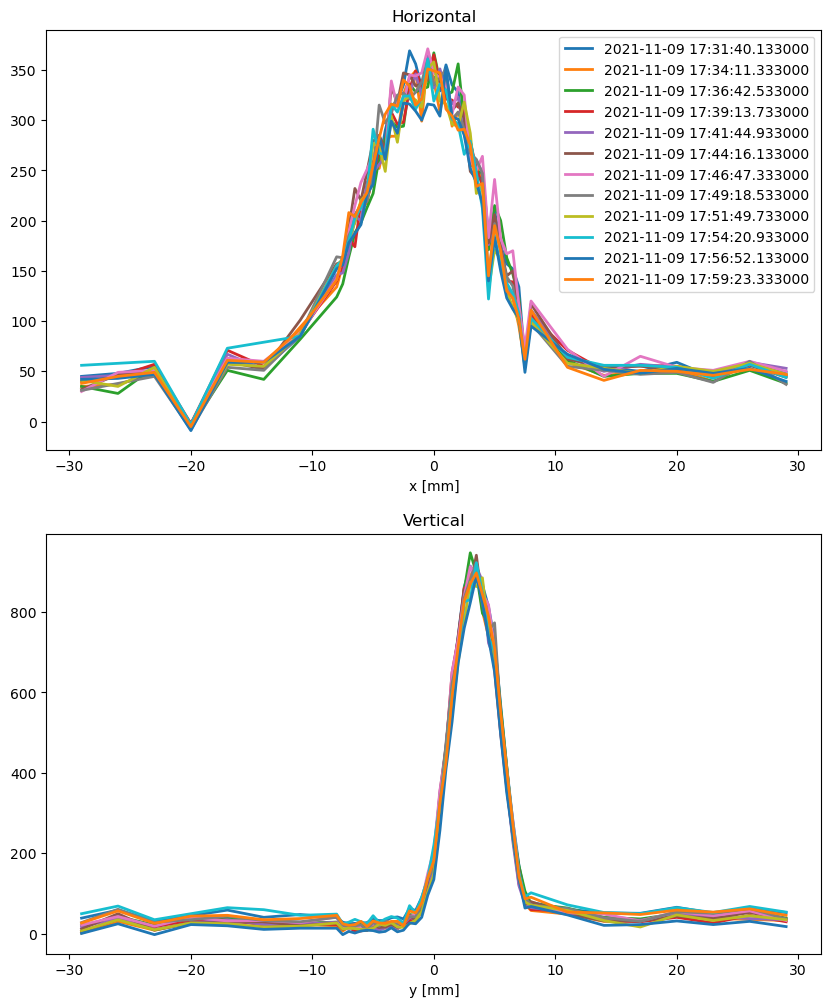

In [37]:
plt.figure(figsize=[10,12])
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

for i, acquisition in enumerate(SEM_profile['LNE50.BSGW.5020:Acquisition:profiles'][1]):
    _time = datetime.datetime.fromtimestamp(SEM_profile['LNE50.BSGW.5020:Acquisition:profiles'][0][i])
    wirespacing_h = SEM_profile['LNE50.BSGW.5020:Acquisition:wirePositions'][1][i][1]
    wirespacing_v = SEM_profile['LNE50.BSGW.5020:Acquisition:wirePositions'][1][i][0]
    ax1.plot(wirespacing_h, acquisition[1], label=_time)
    ax2.plot(wirespacing_v, acquisition[0], label=_time)
ax1.set_title('Horizontal')
ax2.set_title('Vertical')
ax1.set_xlabel('x [mm]')
ax2.set_xlabel('y [mm]')
ax1.legend()

### Look after GBAR size stability

In [4]:
t1 = '2022-06-13 10:00:00.000'
t2 = '2022-06-23 12:00:00.000'


# Get a list of monitors following some "rule", e.g. concatenating different pieces of LNEXX lines
ALL_MONITORS = (ldb.search('LNE50%FitAcq:gaussMean'))

# We will also need to know if the profiles are good, so we need some other field
# Here we use several "tricks" typical of python
# 1. inline creation of a list of elements (in our case will be strings)
#    [ element1, element2, ... ]
# 2. inline *for loop* to make the list of elements
#    [ _do_something_with_element_  for _element_ in _list_of_elements_]
# 3. profit of standard operation on strings, e.g. "split"
#    _my_string_.split(separator_characther, number_of_splits)
# 4. immediatelly take the first element of the list generated by "split" function
#    _my_function_that_returns_a_list()[0] -> returns the first element of the list
# 5. string concatenation
#    "_first_string_" + "_second_string_" = "_first_string__second_string_"
_ALL_MONITORS_IN = [ _monitor.split(':',1)[0]+':Acquisition:isMonitorIn' for _monitor in ALL_MONITORS]

# same for intensity/Amplitude
_ALL_MONITORS_AMPLI = [ _monitor.split(':',1)[0]+':FitAcq:gaussAmplitude' for _monitor in ALL_MONITORS]
_ALL_MONITORS_SIGMA = [ _monitor.split(':',1)[0]+':FitAcq:gaussSigma' for _monitor in ALL_MONITORS]

In [5]:
SEM_position_data  = ldb.get(ALL_MONITORS+_ALL_MONITORS_IN+_ALL_MONITORS_AMPLI+_ALL_MONITORS_SIGMA, t1, t2)